In [1]:
import os
from PIL import Image, ImageFile, PngImagePlugin
Image.MAX_IMAGE_PIXELS = None 
PngImagePlugin.MAX_TEXT_CHUNK = 100 * 1024 * 1024  # 100MB
PngImagePlugin.MAX_TEXT_MEMORY = 100 * 1024 * 1024 # 100MB

ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
from pathlib import Path

dataDir = Path("/media/toom/New Volume/cuhk_data/HPACG_dataHPACG_split")
train_positive_dir = dataDir / "train/positive"
train_negative_dir = dataDir / "train/negative"

test_positive_dir = dataDir / "test/positive"
test_negative_dir = dataDir / "test/negative"

import os
import logging
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import timm
from os.path import join as pjoin
import json
from torchvision.transforms.functional import to_pil_image

In [2]:
from trident.patch_encoder_models import encoder_factory

model = encoder_factory(model_name='hoptimus1')
model.to('cpu')
model.eval()

HOptimus1InferenceEncoder(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): GluMlp(
          (fc1): Linear(in_features=1536, out_features=8192, bias=True)
          (act):

In [5]:
trnsfrms_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.707223, 0.578729, 0.703617), 
        std=(0.211883, 0.230117, 0.177517)
    ),
])

In [6]:
image = Image.open("./test_img.png").convert("RGB")
image = trnsfrms_val(image).unsqueeze(dim=0)
with torch.no_grad():
    patch_feature_emb = model(image)

In [7]:
from os.path import join as j_

train_dataset = torchvision.datasets.ImageFolder(j_(dataDir, 'train'), transform=trnsfrms_val)
test_dataset = torchvision.datasets.ImageFolder(j_(dataDir, 'test'), transform=trnsfrms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=16)

/home/toom/miniconda3/envs/trident/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
from UNI.uni.downstream.eval_patch_features.logistic_regression import LogisticRegression
from UNI.uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from UNI.uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

In [9]:
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

/home/toom/miniconda3/envs/trident/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


100%|██████████| 858/858 [1:34:18<00:00,  6.60s/it]


In [14]:
train_features

{'embeddings': array([[-5.1304942e-01,  6.3603818e-01, -1.2762544e-01, ...,
          2.9665819e-01,  1.4324068e-01,  8.7254390e-04],
        [-2.5258672e-01,  4.1144130e-01, -1.4248217e+00, ...,
          2.2838826e-01, -2.4871181e-01,  4.4314799e-01],
        [-8.0830377e-01,  1.2152311e+00, -7.5867957e-01, ...,
         -4.4575337e-01, -1.3957560e+00, -1.0024990e+00],
        ...,
        [-1.6271762e+00,  4.0420496e-01, -4.2729232e-01, ...,
          2.0730773e-01,  1.8196905e-01,  2.2019280e-01],
        [-5.4020774e-01,  2.5873348e-01, -2.5395492e-01, ...,
         -6.4412899e-02, -1.4688395e+00,  2.9709557e-01],
        [-1.0955197e+00,  5.8584172e-01, -8.1076807e-01, ...,
         -2.9102029e-02,  1.5106436e+00,  2.7583426e-01]],
       shape=(8005, 1536), dtype=float32),
 'labels': array([0, 0, 0, ..., 1, 1, 1], shape=(8005,))}

In [21]:
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

all_feats = torch.concat([train_feats, test_feats])
all_labels = torch.concat([train_labels, test_labels])

In [11]:
from UNI.uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([8005, 1536])
Linear Probe Evaluation: Test shape torch.Size([3432, 1536])
Linear Probe Evaluation (Train Time): Best cost = 30.720
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([8005, 1536])
(Before Training) Loss: 0.693
(After Training) Loss: 0.295
Linear Probe Evaluation (Test Time): Test Shape torch.Size([3432, 1536])
Linear Probe Evaluation: Time taken 1.04
Test lin_acc: 0.825
Test lin_bacc: 0.824
Test lin_kappa: 0.648
Test lin_weighted_f1: 0.825
Test lin_auroc: 0.913


True Positive Rate (Sensitivity,recall): [0.811]
False Positive Rate : [0.163]
Specificity : [0.837]
Balanced Accuracy : [0.824]
Precision: [0.810]


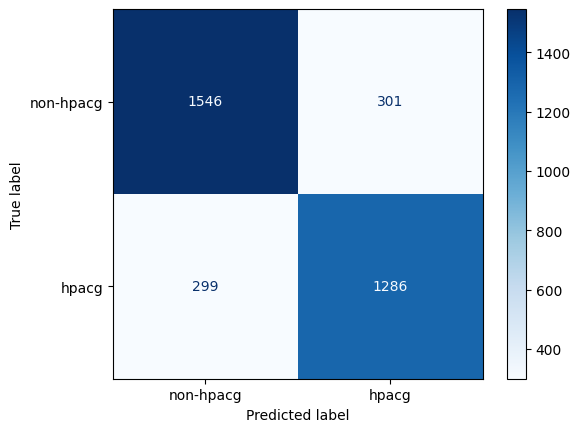

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_true = linprobe_dump['preds_all']
y_pred = linprobe_dump['targets_all']
cm = confusion_matrix(y_true, y_pred)

labels = ['non-hpacg', 'hpacg']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

TN, FP, FN, TP = confusion_matrix=cm.ravel()

tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
specificity = TN / (TN + FP) if (FP + TN) > 0 else 0
Balanced_Accuracy = (specificity + tpr) / 2
Precision = TP  / (TP + FP) if (TP + FP) > 0 else 0
Weight_F1 = ((Precision * tpr) / (Precision + tpr))*2

print(f"True Positive Rate (Sensitivity,recall): [{tpr:.3f}]")
print(f"False Positive Rate : [{fpr:.3f}]")
print(f"Specificity : [{specificity:.3f}]")
print(f"Balanced Accuracy : [{Balanced_Accuracy:.3f}]")
print(f"Precision: [{Precision:.3f}]")

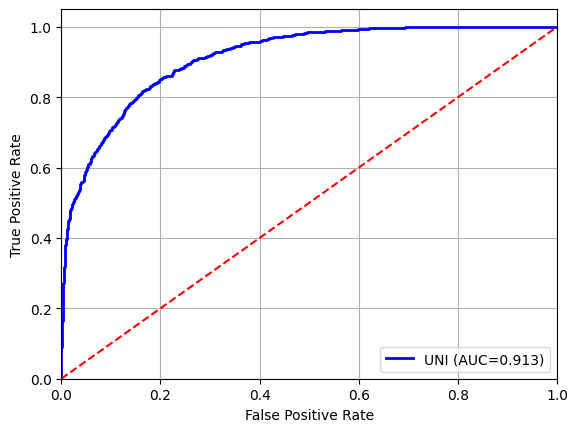

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

true_labels = linprobe_dump['targets_all']
pred_probs = linprobe_dump['probs_all']

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'UNI (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()